In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_HIGHTOL.csv')
df_v = pd.read_csv('Dataframes/3rdBodyPerturbationPoliastro_vv_HIGHTOL.csv')

df['x_vv']=df_v.vv_x
df['y_vv']=df_v.vv_y
df['z_vv']=df_v.vv_z

In [3]:
# Full 6D r,v elements

df

,x,y,z,x_vv,y_vv,z_vv
0,42159.783600,0.000000,0.000000,0.000000,3.074505,0.053666
1,39159.545489,15563.916192,266.913396,-1.142984,2.852848,0.048528
2,30572.240101,28909.065576,496.928457,-2.127756,2.228986,0.039518
3,17596.058985,38144.724801,671.355898,-2.813645,1.287414,0.027234
4,2068.443209,41949.722913,775.646911,-3.098444,0.161674,0.012698
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


Function to train model on ONE column:

In [24]:
#Function

def train_vector(df, str):
    
    #Create a new dataframe with only the column
    data = df.filter([str]) # CHANGE FOR Y,Z
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * 0.8 ))
    train=dataset[0 : training_data_len]
    test=dataset[training_data_len - 60 : ]

    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train)
    test_data=scaler.transform(test)
    
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            pass
            #print(x_train)
            #print(y_train)
            #print()      
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    #Create the testing data set
    #Create a new array containing scaled values
    #Create the data sets x_test and y_test
    x_test = []
    #y_test = dataset[training_data_len:, :]
    y_test = dataset[training_data_len : ]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    
    #Build the LSTM model
    # Note: replace LSTM with GRU or RNN if you want to try those
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    #Train the model
    model.fit(x_train, y_train, batch_size=256, epochs=100) # 100 epochs
    
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    #print(predictions)
    pred=np.reshape(predictions, (predictions.shape[0]))
    pred_s=pd.Series(pred)
    # Init empty predictions DF
    #df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])
    df_pred[str]=pred_s
    
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('\n RMSE:')
    print(rmse)
    
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Visualization of vector '+str)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel(str+'-Coord', fontsize=18)
    plt.plot(train[str])
    plt.plot(valid[[str, 'Predictions']])
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    plt.show()

    # Error plot
    valid['Error']=abs(valid.Predictions-valid[str])/6738 # the normalization ct is taken as ISS semi-major axis
    valid.Error.plot()
    
    #Output dataframe of predictions in 6 dimensions r,v
    return df_pred

We want to train all the 6 separate state space elements:

Epoch 1/100
3/3 [==============================] - 1s 327ms/step - loss: 0.2148
Epoch 2/100
3/3 [==============================] - 1s 340ms/step - loss: 0.1547
Epoch 3/100
3/3 [==============================] - 1s 273ms/step - loss: 0.1325
Epoch 4/100
3/3 [==============================] - 1s 333ms/step - loss: 0.1321
Epoch 5/100
3/3 [==============================] - 1s 322ms/step - loss: 0.1178
Epoch 6/100
3/3 [==============================] - 1s 332ms/step - loss: 0.1088
Epoch 7/100
3/3 [==============================] - 1s 336ms/step - loss: 0.0983
Epoch 8/100
3/3 [==============================] - 1s 329ms/step - loss: 0.0850
Epoch 9/100
3/3 [==============================] - 1s 375ms/step - loss: 0.0681
Epoch 10/100
3/3 [==============================] - 1s 324ms/step - loss: 0.0471
Epoch 11/100
3/3 [==============================] - 1s 314ms/step - loss: 0.0210
Epoch 12/100
3/3 [==============================] - 1s 335ms/step - loss: 0.0032
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 350ms/step - loss: 1.1983e-04
Epoch 99/100
3/3 [==============================] - 1s 328ms/step - loss: 1.1226e-04
Epoch 100/100
3/3 [==============================] - 1s 335ms/step - loss: 1.1760e-04

 RMSE:
1097.466876415768


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


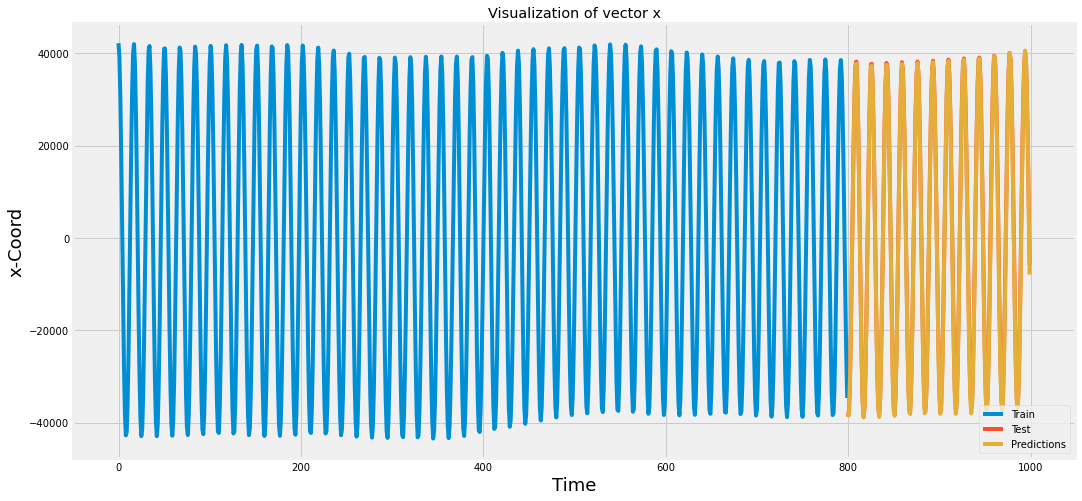

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 334ms/step - loss: 0.2702
Epoch 2/100
3/3 [==============================] - 1s 344ms/step - loss: 0.1800
Epoch 3/100
3/3 [==============================] - 1s 365ms/step - loss: 0.1432
Epoch 4/100
3/3 [==============================] - 1s 346ms/step - loss: 0.1490
Epoch 5/100
3/3 [==============================] - 1s 355ms/step - loss: 0.1479
Epoch 6/100
3/3 [==============================] - 1s 338ms/step - loss: 0.1323
Epoch 7/100
3/3 [==============================] - 1s 359ms/step - loss: 0.1234
Epoch 8/100
3/3 [==============================] - 1s 361ms/step - loss: 0.1221
Epoch 9/100
3/3 [==============================] - 1s 356ms/step - loss: 0.1141
Epoch 10/100
3/3 [==============================] - 1s 350ms/step - loss: 0.1054
Epoch 11/100
3/3 [==============================] - 1s 354ms/step - loss: 0.0997
Epoch 12/100
3/3 [==============================] - 1s 339ms/step - loss: 0.0875
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 338ms/step - loss: 1.8227e-04
Epoch 99/100
3/3 [==============================] - 1s 337ms/step - loss: 1.8023e-04
Epoch 100/100
3/3 [==============================] - 1s 315ms/step - loss: 1.7681e-04

 RMSE:
733.9251616375727


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


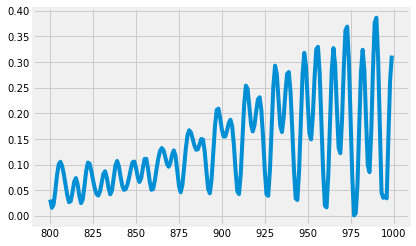

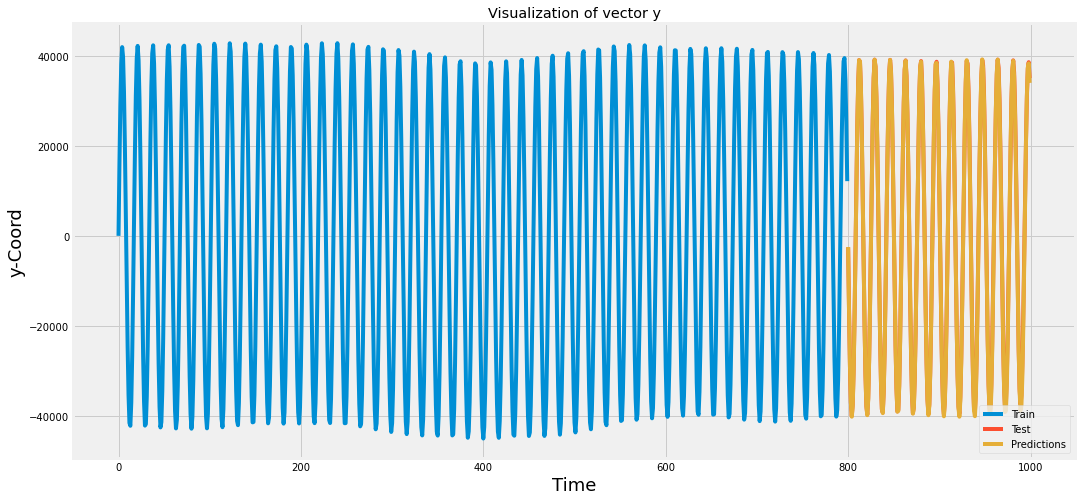

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 421ms/step - loss: 0.1540
Epoch 2/100
3/3 [==============================] - 1s 271ms/step - loss: 0.0855
Epoch 3/100
3/3 [==============================] - 1s 285ms/step - loss: 0.0678
Epoch 4/100
3/3 [==============================] - 1s 325ms/step - loss: 0.0709
Epoch 5/100
3/3 [==============================] - 1s 299ms/step - loss: 0.0658
Epoch 6/100
3/3 [==============================] - 1s 304ms/step - loss: 0.0584
Epoch 7/100
3/3 [==============================] - 1s 263ms/step - loss: 0.0594
Epoch 8/100
3/3 [==============================] - 1s 288ms/step - loss: 0.0568
Epoch 9/100
3/3 [==============================] - 1s 299ms/step - loss: 0.0530
Epoch 10/100
3/3 [==============================] - 1s 404ms/step - loss: 0.0522
Epoch 11/100
3/3 [==============================] - 1s 279ms/step - loss: 0.0501
Epoch 12/100
3/3 [==============================] - 1s 288ms/step - loss: 0.0471
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 310ms/step - loss: 9.4708e-05
Epoch 99/100
3/3 [==============================] - 1s 327ms/step - loss: 9.5543e-05
Epoch 100/100
3/3 [==============================] - 1s 332ms/step - loss: 9.5511e-05

 RMSE:
506.1758582694058


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


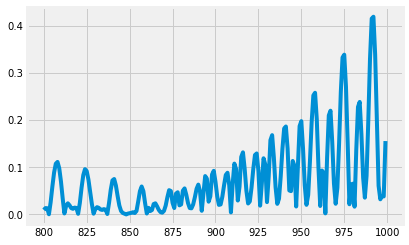

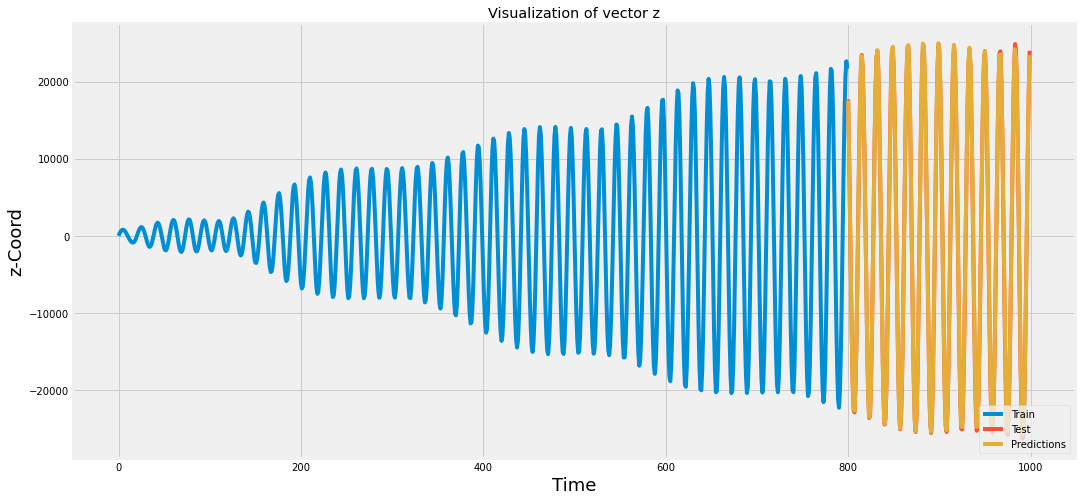

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 329ms/step - loss: 0.2634
Epoch 2/100
3/3 [==============================] - 1s 329ms/step - loss: 0.1626
Epoch 3/100
3/3 [==============================] - 1s 314ms/step - loss: 0.1367
Epoch 4/100
3/3 [==============================] - 1s 336ms/step - loss: 0.1362
Epoch 5/100
3/3 [==============================] - 1s 384ms/step - loss: 0.1316
Epoch 6/100
3/3 [==============================] - 1s 323ms/step - loss: 0.1147
Epoch 7/100
3/3 [==============================] - 1s 266ms/step - loss: 0.1074
Epoch 8/100
3/3 [==============================] - 1s 310ms/step - loss: 0.1002
Epoch 9/100
3/3 [==============================] - 1s 293ms/step - loss: 0.0865
Epoch 10/100
3/3 [==============================] - 1s 323ms/step - loss: 0.0740
Epoch 11/100
3/3 [==============================] - 1s 322ms/step - loss: 0.0542
Epoch 12/100
3/3 [==============================] - 1s 314ms/step - loss: 0.0306
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 380ms/step - loss: 1.9484e-04
Epoch 99/100
3/3 [==============================] - 1s 277ms/step - loss: 1.9224e-04
Epoch 100/100
3/3 [==============================] - 1s 317ms/step - loss: 1.9445e-04

 RMSE:
0.06330195855798007


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


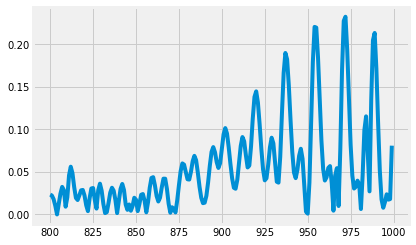

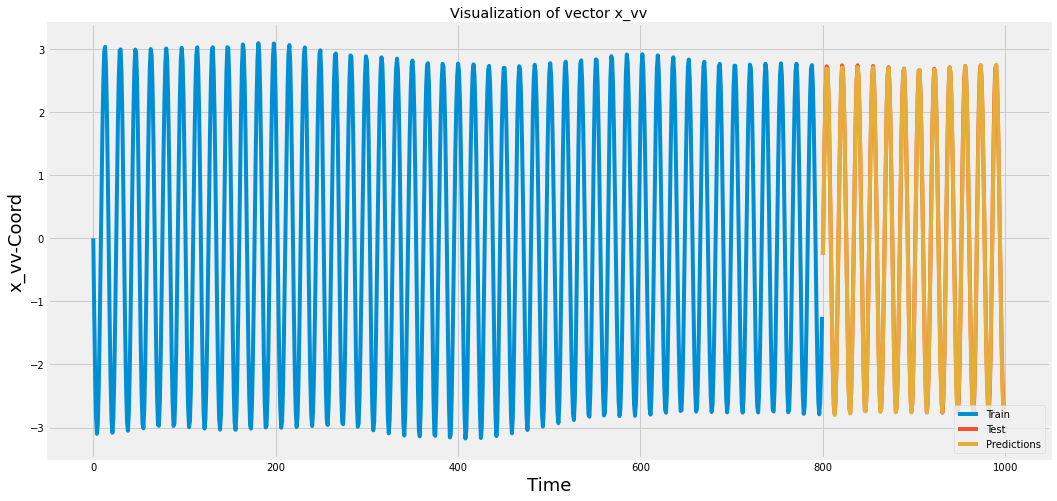

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 330ms/step - loss: 0.3106
Epoch 2/100
3/3 [==============================] - 1s 266ms/step - loss: 0.1610
Epoch 3/100
3/3 [==============================] - 1s 272ms/step - loss: 0.1555
Epoch 4/100
3/3 [==============================] - 1s 279ms/step - loss: 0.1347
Epoch 5/100
3/3 [==============================] - 1s 283ms/step - loss: 0.1365
Epoch 6/100
3/3 [==============================] - 1s 289ms/step - loss: 0.1265
Epoch 7/100
3/3 [==============================] - 1s 286ms/step - loss: 0.1130
Epoch 8/100
3/3 [==============================] - 1s 268ms/step - loss: 0.1060
Epoch 9/100
3/3 [==============================] - 1s 275ms/step - loss: 0.0971
Epoch 10/100
3/3 [==============================] - 1s 219ms/step - loss: 0.0814
Epoch 11/100
3/3 [==============================] - 1s 242ms/step - loss: 0.0670
Epoch 12/100
3/3 [==============================] - 1s 302ms/step - loss: 0.0441
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 325ms/step - loss: 2.2309e-04
Epoch 99/100
3/3 [==============================] - 1s 343ms/step - loss: 2.1832e-04
Epoch 100/100
3/3 [==============================] - 1s 323ms/step - loss: 2.1849e-04

 RMSE:
0.07002251227530282


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


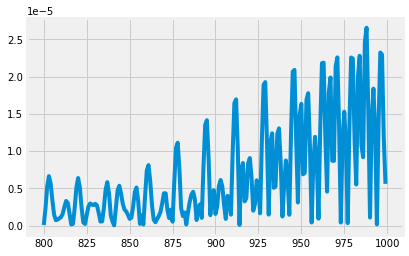

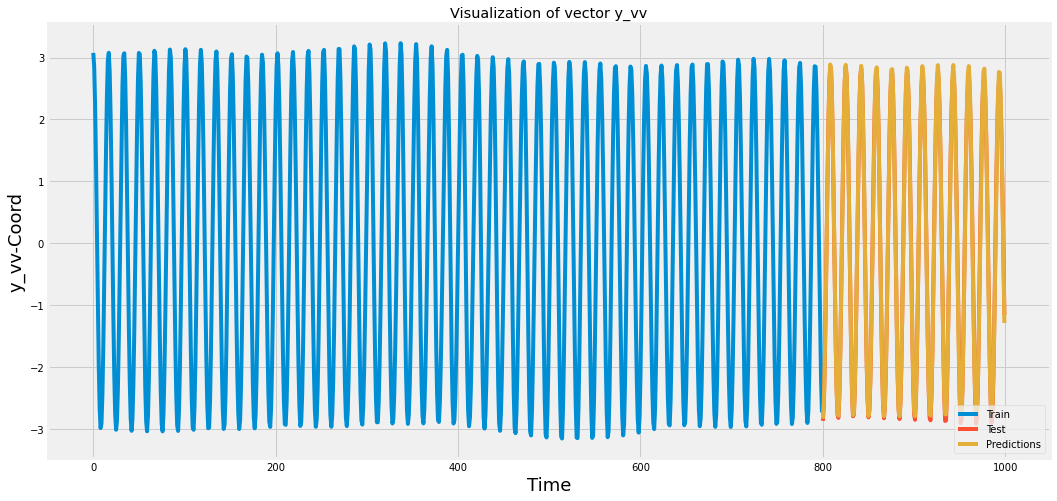

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/100
3/3 [==============================] - 1s 349ms/step - loss: 0.1861
Epoch 2/100
3/3 [==============================] - 1s 371ms/step - loss: 0.0973
Epoch 3/100
3/3 [==============================] - 1s 351ms/step - loss: 0.0717
Epoch 4/100
3/3 [==============================] - 1s 352ms/step - loss: 0.0720
Epoch 5/100
3/3 [==============================] - 1s 343ms/step - loss: 0.0750
Epoch 6/100
3/3 [==============================] - 1s 350ms/step - loss: 0.0654
Epoch 7/100
3/3 [==============================] - 1s 344ms/step - loss: 0.0610
Epoch 8/100
3/3 [==============================] - 1s 348ms/step - loss: 0.0621
Epoch 9/100
3/3 [==============================] - 1s 455ms/step - loss: 0.0586
Epoch 10/100
3/3 [==============================] - 1s 342ms/step - loss: 0.0552
Epoch 11/100
3/3 [==============================] - 1s 356ms/step - loss: 0.0550
Epoch 12/100
3/3 [==============================] - 1s 352ms/step - loss: 0.0536
Epoch 13/100
3/3 [===================

3/3 [==============================] - 1s 349ms/step - loss: 1.2001e-04
Epoch 99/100
3/3 [==============================] - 1s 350ms/step - loss: 1.1949e-04
Epoch 100/100
3/3 [==============================] - 1s 369ms/step - loss: 1.1114e-04

 RMSE:
0.03846777191451581


C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


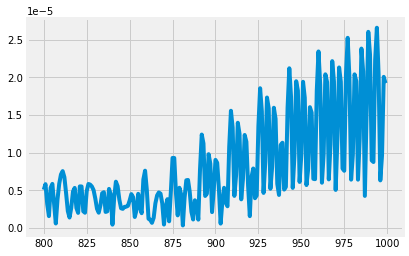

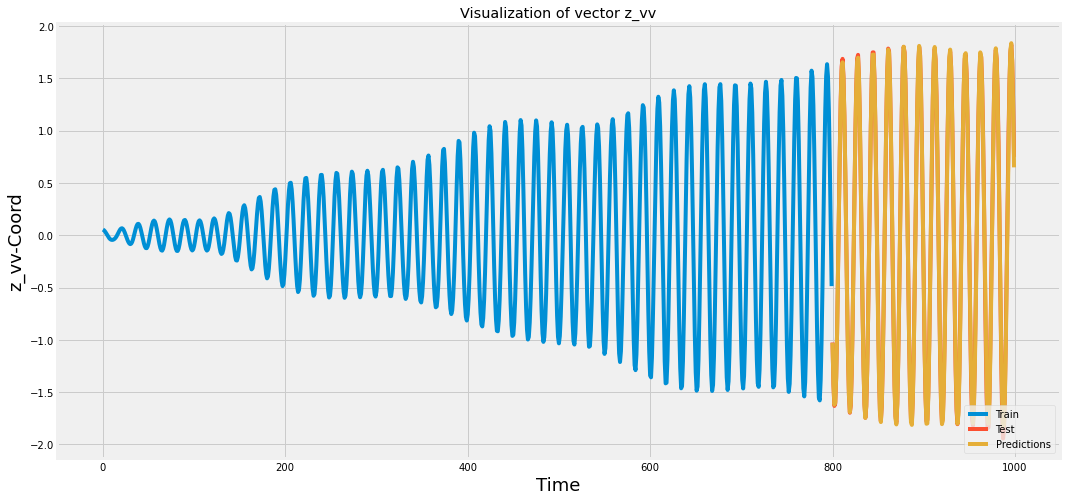

C:\Users\Vlad\anaconda3\envs\poliastro\lib\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,x,y,z,x_vv,y_vv,z_vv
0,-38838.199219,-2485.511475,17525.253906,-0.256750,-2.836282,-1.029876
1,-37388.773438,-16848.806641,11092.200195,0.753165,-2.571034,-1.424029
2,-30976.736328,-28916.923828,3087.357422,1.653891,-1.964219,-1.620908
3,-20486.832031,-37065.429688,-5370.635254,2.328333,-1.096202,-1.595651
4,-7309.367676,-40198.714844,-13103.020508,2.688453,-0.077019,-1.353589
...,...,...,...,...,...,...
195,38498.156250,20712.882812,-7631.756836,-0.950866,2.347357,1.768962
196,31362.154297,31272.753906,1782.335938,-1.833073,1.620837,1.835884
197,20137.193359,37418.738281,10896.771484,-2.455790,0.681191,1.649219
198,6395.530273,38342.304688,18463.605469,-2.737295,-0.335263,1.235056


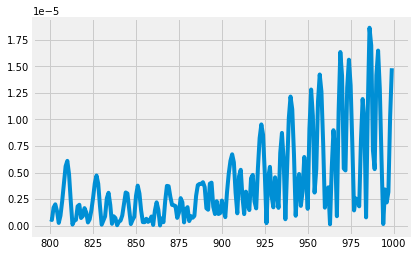

In [25]:
# 6D Call:

# Init empty predictions DF
df_pred= pd.DataFrame(columns=['x', 'y', 'z', 'x_vv', 'y_vv', 'z_vv'])

for vector in list(df.columns):
    train_vector(df, vector)

df_pred

In [26]:
# Transform this df_pred to OE with the function transform.py

### Compare and plot results/errors SEPARATELY

In [27]:
train_size = int(len(df) * 0.8) 

test_df = df[train_size:]
train_df = df[:train_size]

test_df

,x,y,z,x_vv,y_vv,z_vv
800,-38621.084811,-2550.946846,17682.193978,-0.257209,-2.870446,-1.025837
801,-37279.380962,-16940.060722,11242.557363,0.768795,-2.610164,-1.427567
802,-30825.302422,-29006.586493,3208.718635,1.689373,-1.985552,-1.632349
803,-20158.481503,-37068.221540,-5302.080061,2.373066,-1.085660,-1.609145
804,-6770.864726,-40022.999588,-13103.503585,2.726621,-0.041149,-1.362677
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,-0.857195,2.210305,1.746021
996,31594.564686,31056.038869,1622.694286,-1.676526,1.578339,1.821188
997,21172.777063,37155.711937,10779.298456,-2.301089,0.745975,1.670545
998,8179.033302,38600.411058,18585.398385,-2.656710,-0.200198,1.303776


In [28]:
df_pred.index=test_df.index

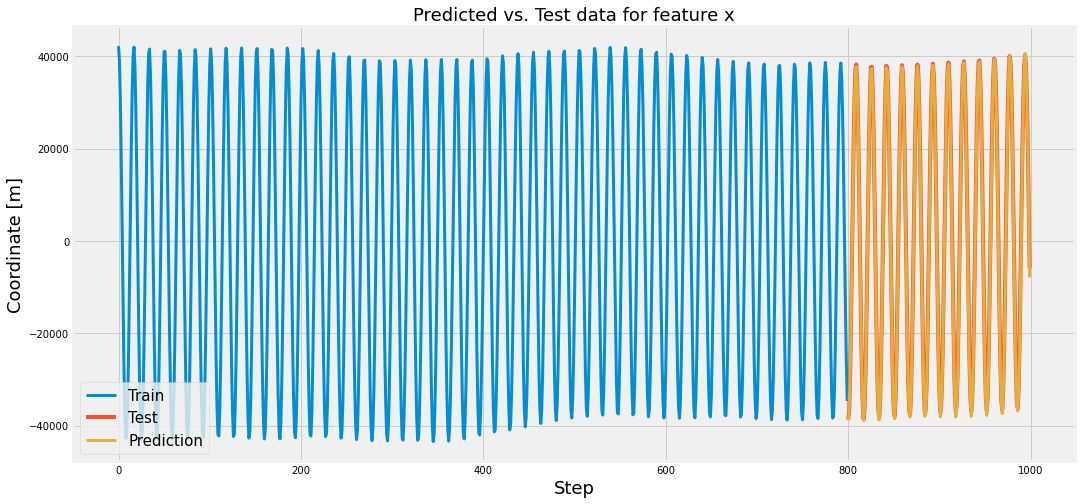

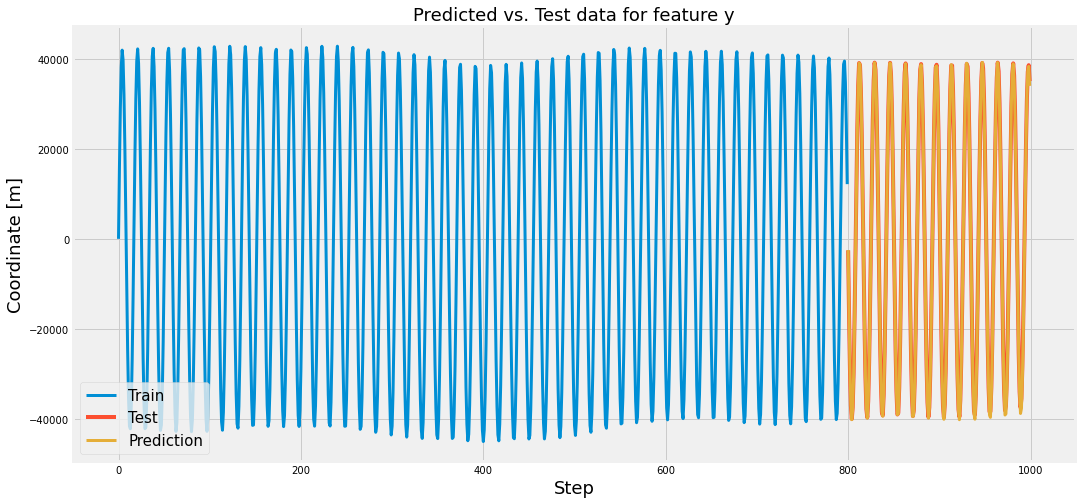

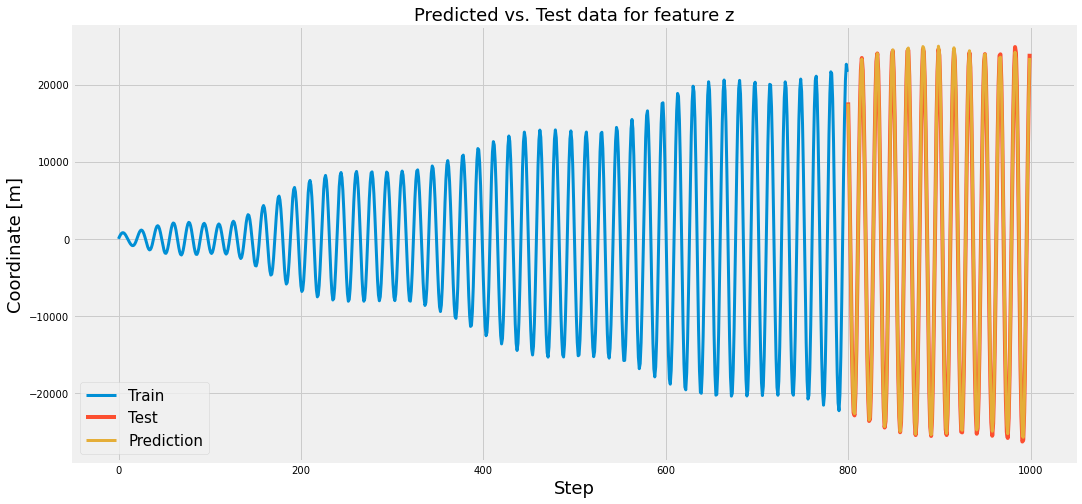

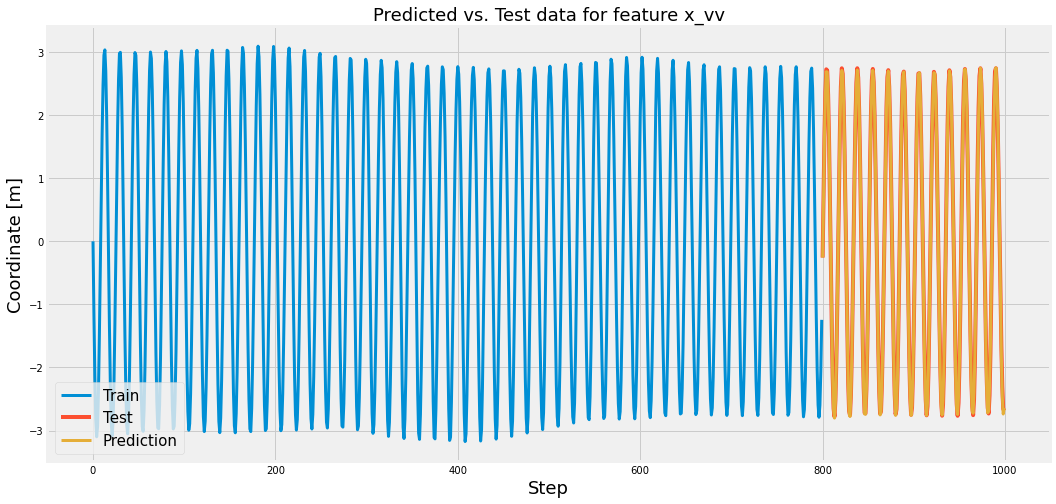

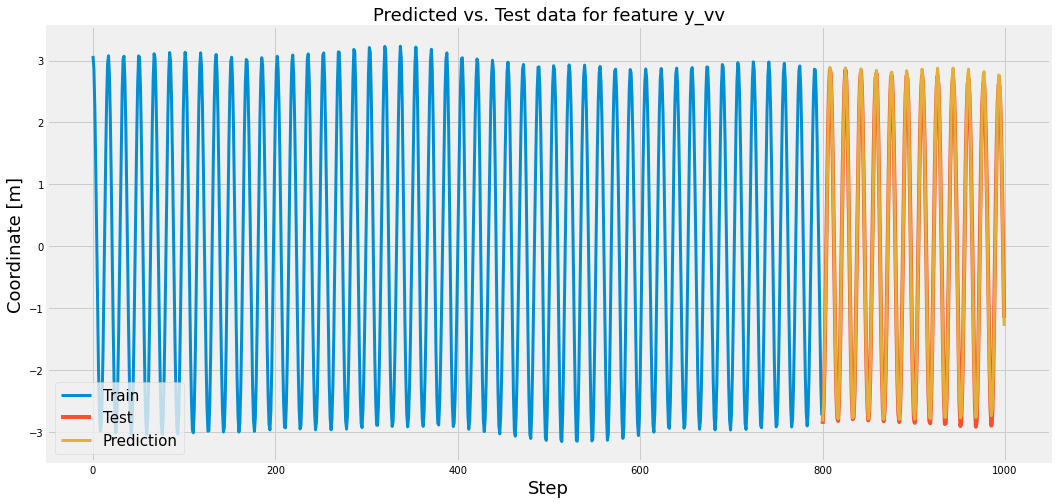

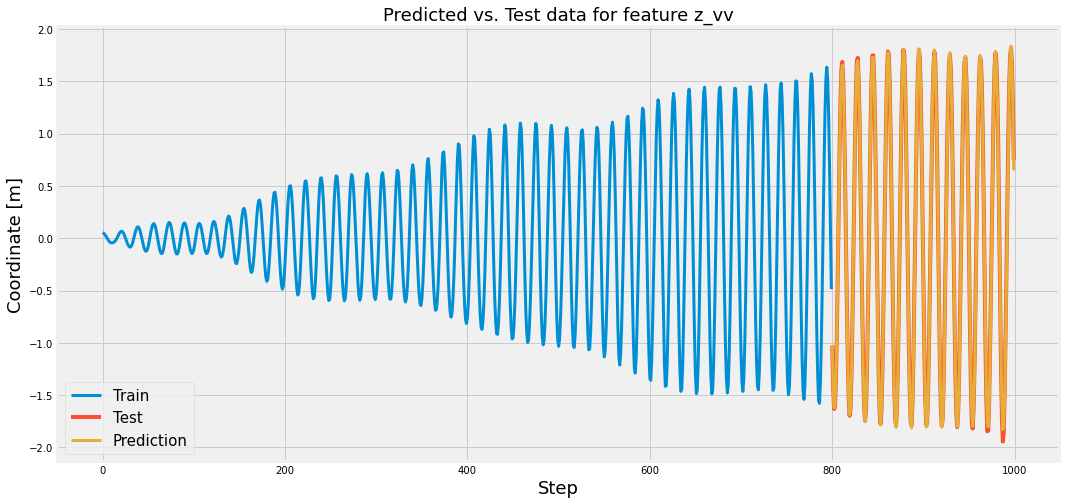

In [54]:
for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(train_df[feature], linewidth=3)
    plt.plot(test_df[feature], linewidth=4)
    plt.plot(df_pred[feature], linewidth=3)

    plt.title(f'Predicted vs. Test data for feature {feature}', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Coordinate [m]', fontsize=18)
    plt.legend(['Train', 'Test', 'Prediction'], loc='lower left', fontsize=15)
    plt.show()


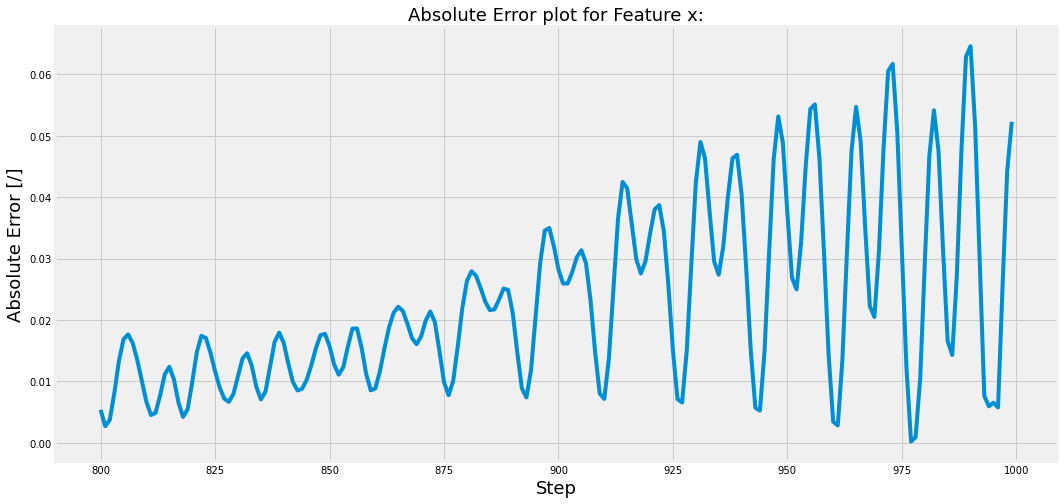

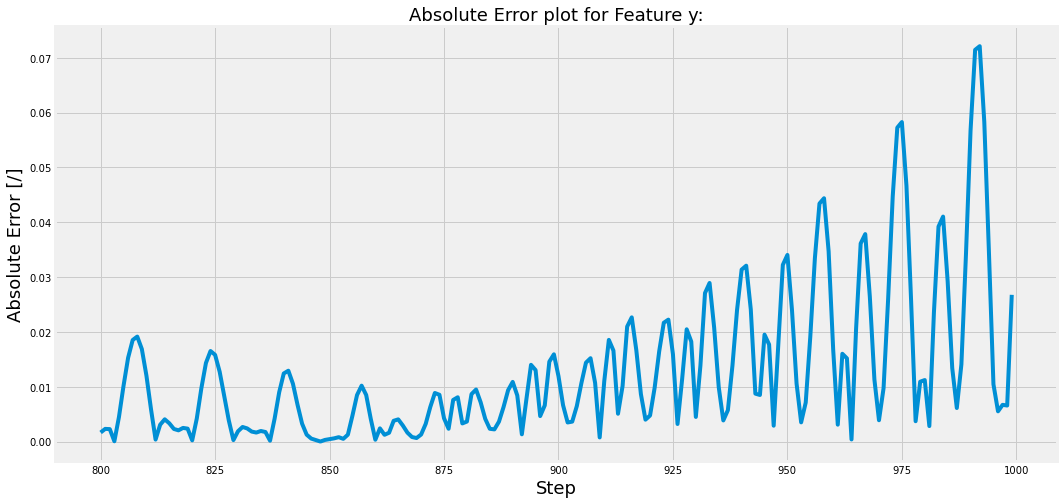

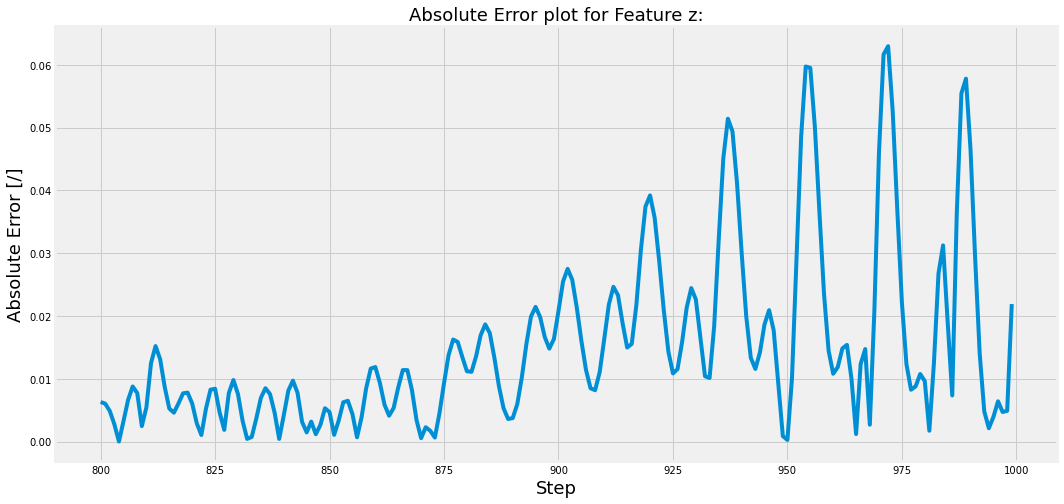

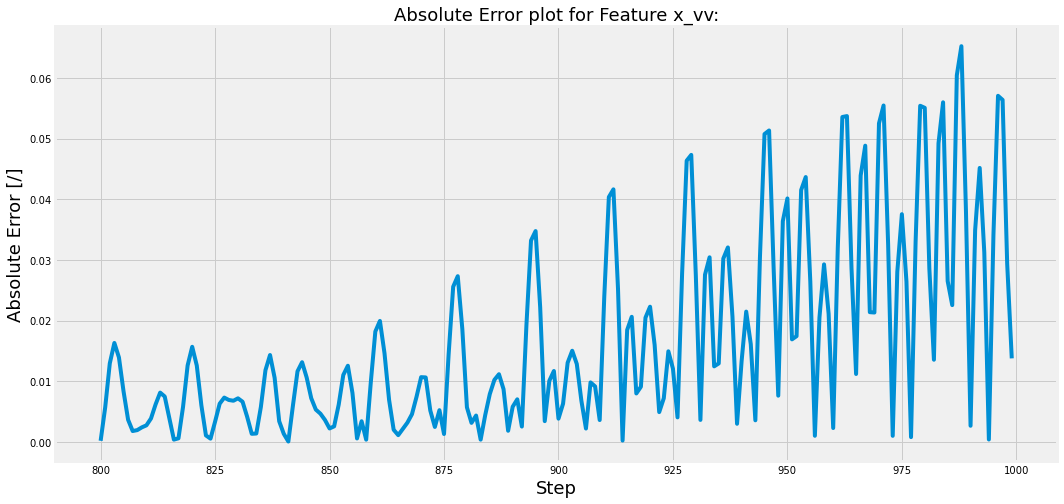

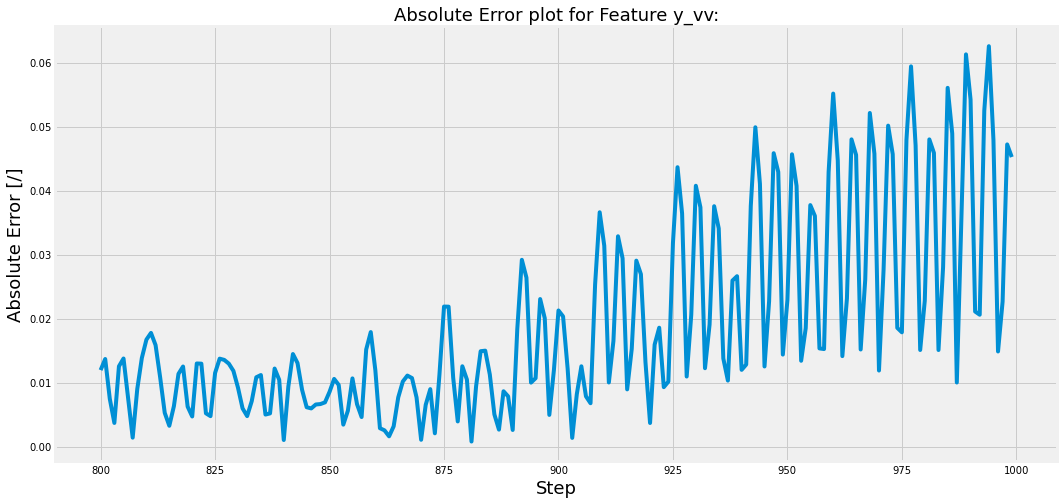

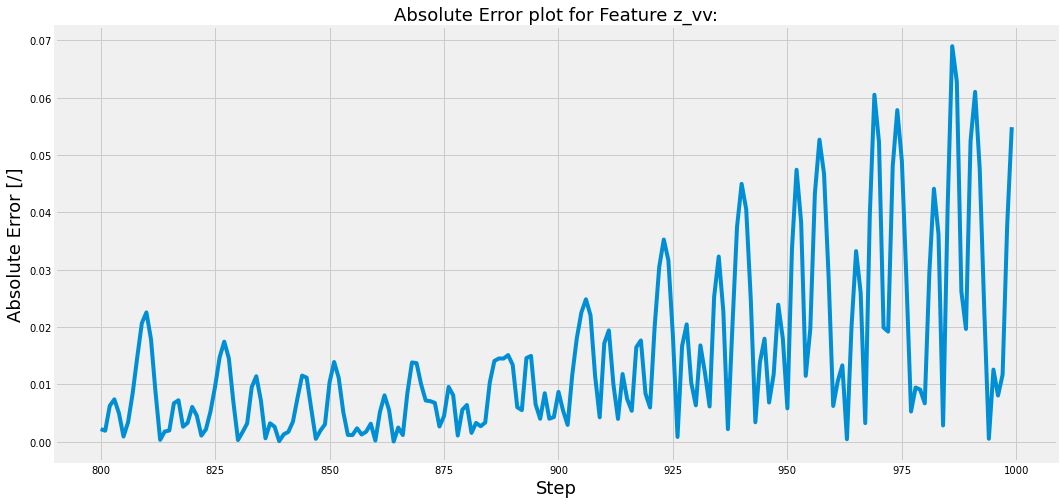

In [57]:
# ABSOLUTE ERRORS:

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/max(test_df[feature]))

    plt.title(f'Absolute Error plot for Feature {feature}:', fontsize=18)
    plt.xlabel('Step', fontsize=18)
    plt.ylabel('Absolute Error [/]', fontsize=18)
    plt.show()

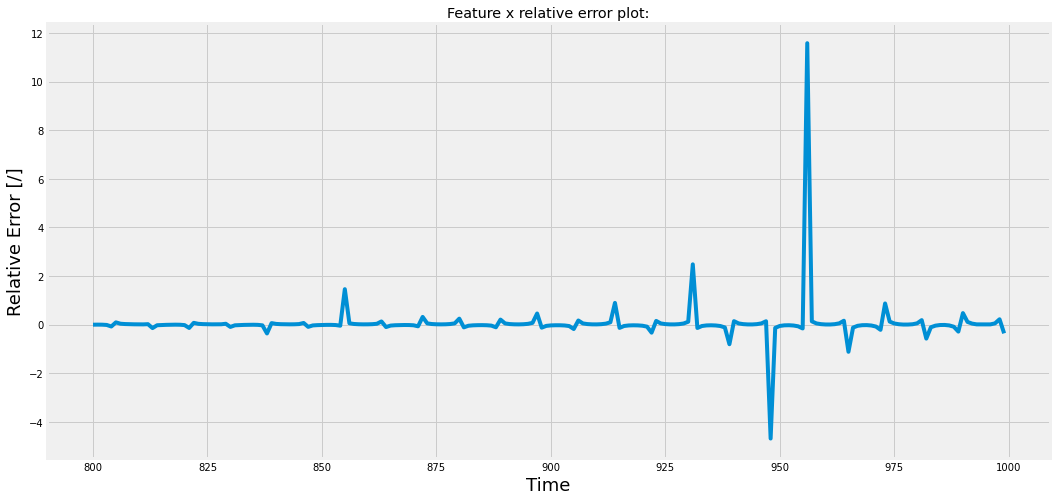

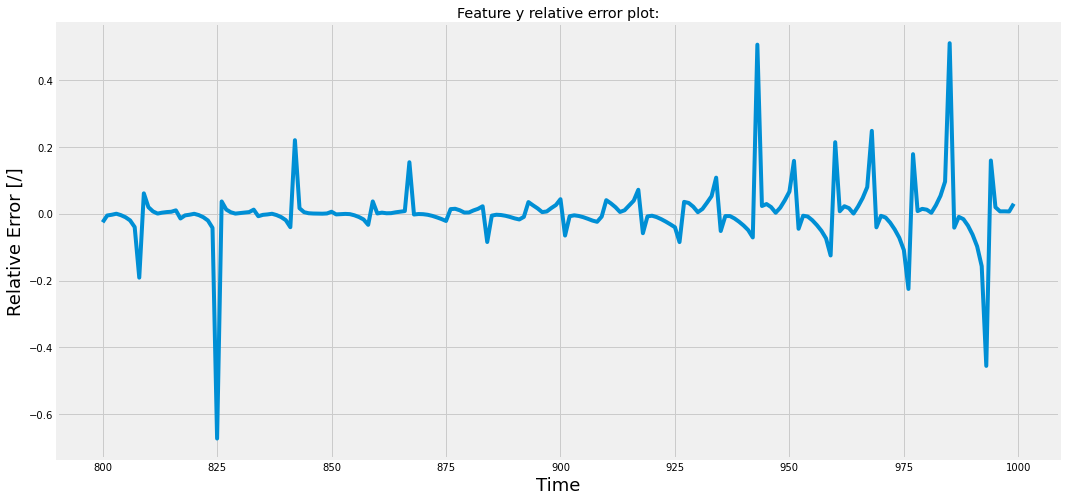

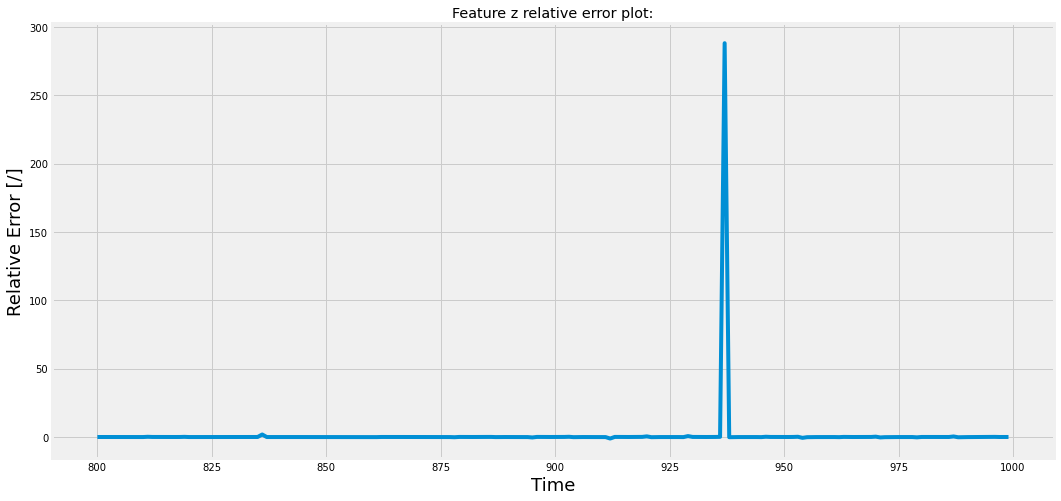

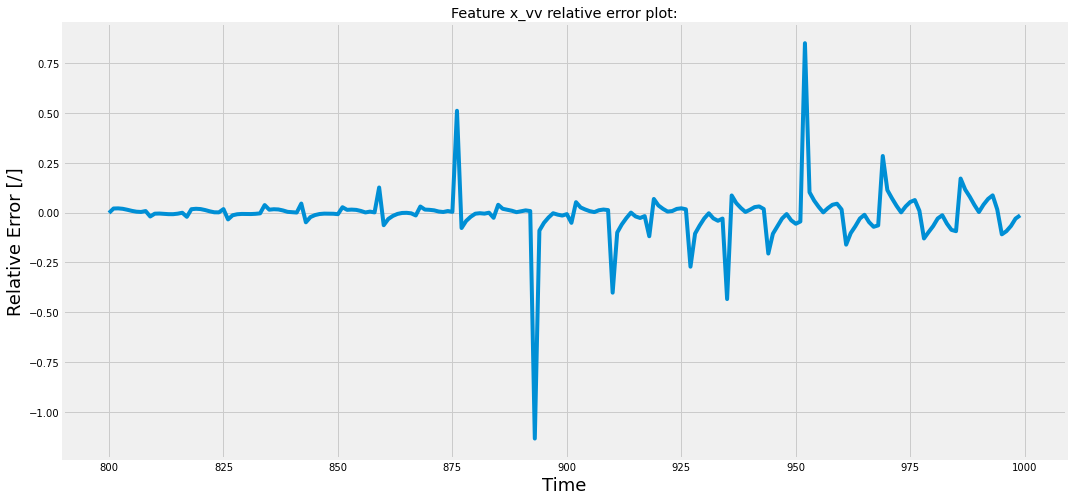

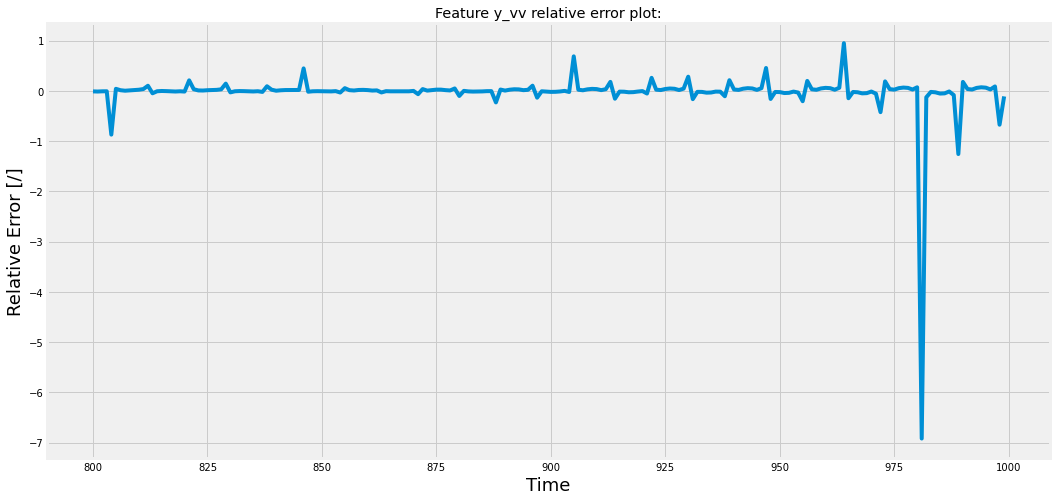

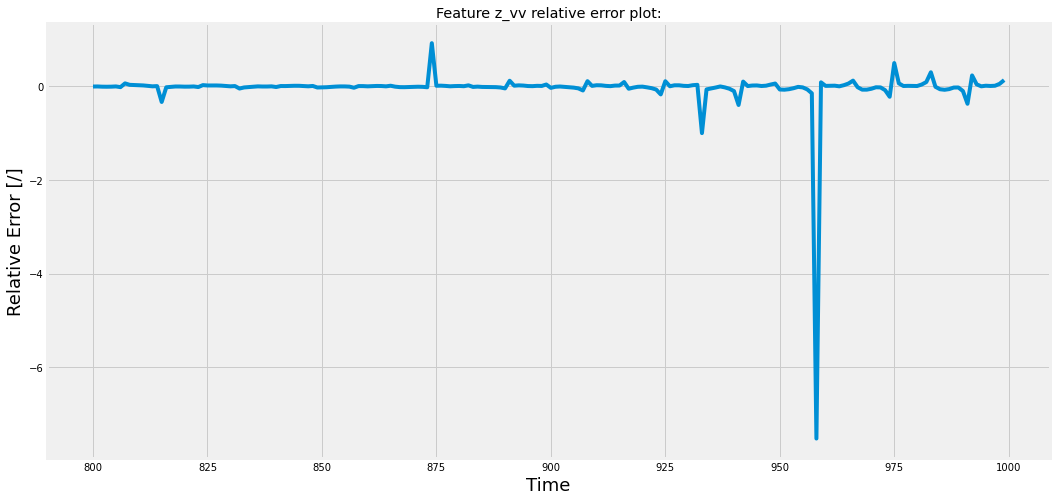

In [31]:
# RELATIVE ERRORS

for feature in list(test_df.columns):
    
    plt.figure(figsize=(16,8))

    plt.plot(abs(df_pred[feature]-test_df[feature])/test_df[feature])

    plt.title(f'Feature {feature} relative error plot:')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Relative Error [/]', fontsize=18)
    plt.show()

## Compare and Plot 3D trajectories/errors:

### 1. For 3D Position coordinates

<Figure size 432x288 with 0 Axes>

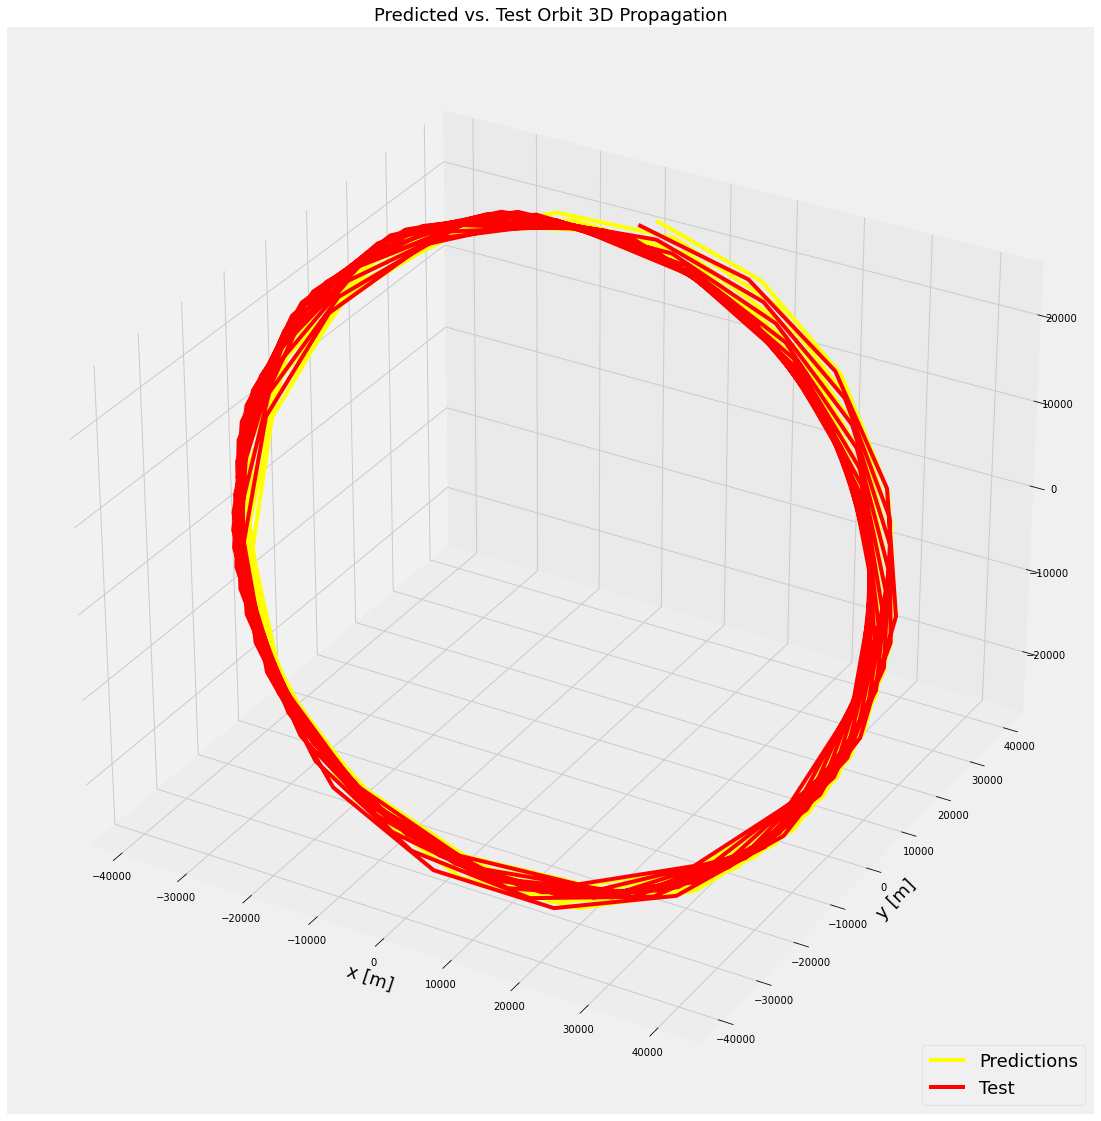

In [61]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")

x_line2 = test_df['x']
y_line2 = test_df['y']
z_line2 = test_df['z']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

x_line = df_pred['x']
y_line = df_pred['y']
z_line = df_pred['z']
plt.plot(x_line, y_line, z_line, 'red')

plt.title('Predicted vs. Test Orbit 3D Propagation', fontsize=18)
plt.xlabel('x [m]', fontsize=18)
plt.ylabel('y [m]', fontsize=18)
#plt.zlabel('z [m]', fontsize=18)
plt.legend(['Predictions', 'Test'], loc='lower right', fontsize=18)
plt.show()

### 2. For 3D velocity coordinates

<Figure size 432x288 with 0 Axes>

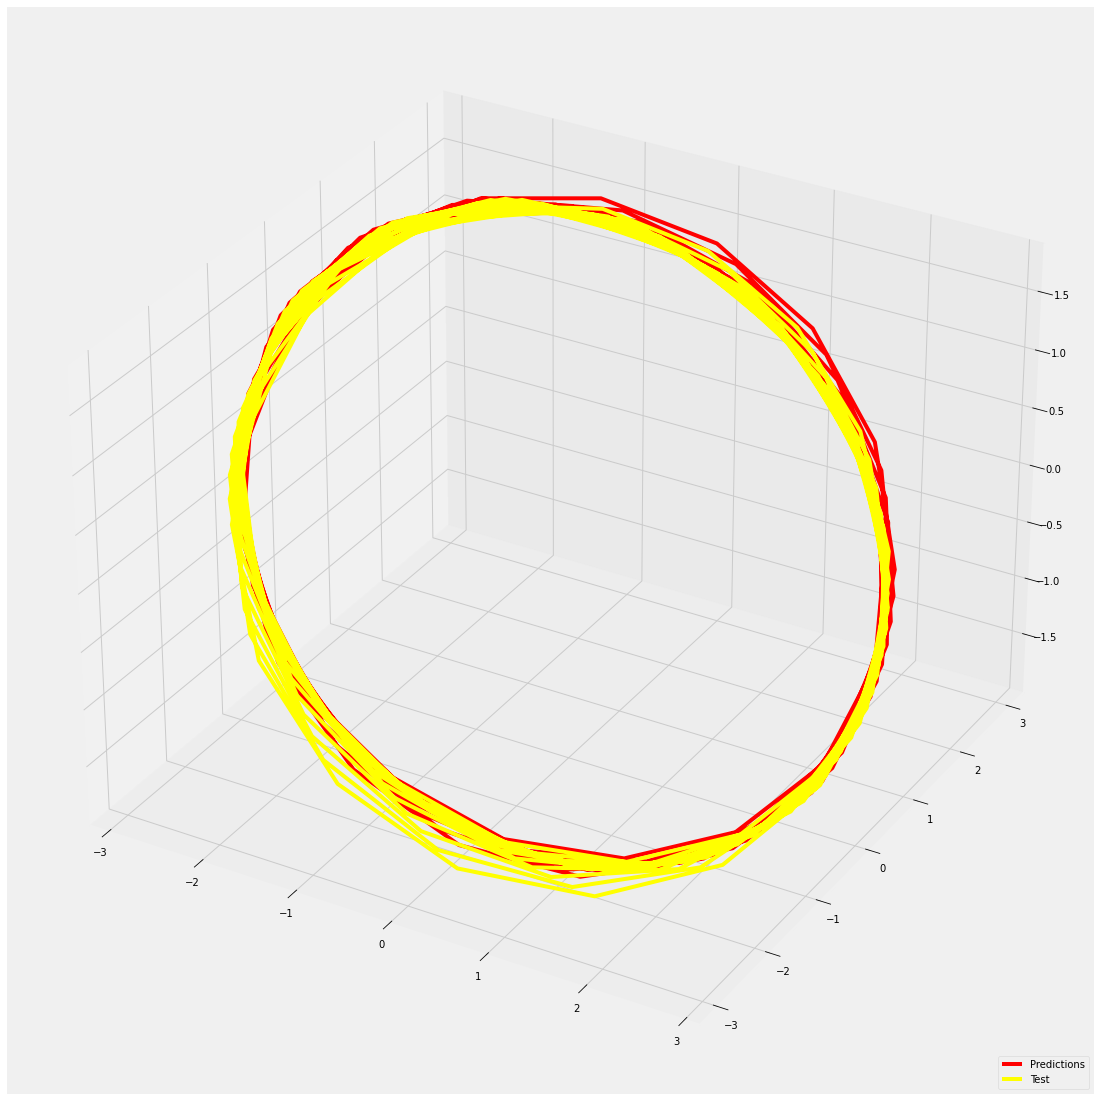

In [33]:
fig = plt.figure()
plt.figure(figsize=(50,20))

plt.axes(projection="3d")
x_line = df_pred['x_vv']
y_line = df_pred['y_vv']
z_line = df_pred['z_vv']
plt.plot(x_line, y_line, z_line, 'red')

x_line2 = test_df['x_vv']
y_line2 = test_df['y_vv']
z_line2 = test_df['z_vv']
plt.plot(x_line2, y_line2, z_line2, 'yellow')

plt.legend(['Predictions', 'Test'], loc='lower right')
plt.show()

## 3D Errors

### 1. Distance Error

https://www.engineeringtoolbox.com/distance-relationship-between-two-points-d_1854.html

In [34]:
# Init empty DF for errors
df_err= pd.DataFrame(columns=['x_test', 'y_test', 'z_test', 'x_pred', 'y_pred', 'z_pred'])

df_err['x_test']=test_df['x']
df_err['y_test']=test_df['y']
df_err['z_test']=test_df['z']

df_err['x_pred']=df_pred['x']
df_err['y_pred']=df_pred['y']
df_err['z_pred']=df_pred['z']

df_err

,x_test,y_test,z_test,x_pred,y_pred,z_pred
800,-38621.084811,-2550.946846,17682.193978,-38838.199219,-2485.511475,17525.253906
801,-37279.380962,-16940.060722,11242.557363,-37388.773438,-16848.806641,11092.200195
802,-30825.302422,-29006.586493,3208.718635,-30976.736328,-28916.923828,3087.357422
803,-20158.481503,-37068.221540,-5302.080061,-20486.832031,-37065.429688,-5370.635254
804,-6770.864726,-40022.999588,-13103.503585,-7309.367676,-40198.714844,-13103.020508
...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,38498.156250,20712.882812,-7631.756836
996,31594.564686,31056.038869,1622.694286,31362.154297,31272.753906,1782.335938
997,21172.777063,37155.711937,10779.298456,20137.193359,37418.738281,10896.771484
998,8179.033302,38600.411058,18585.398385,6395.530273,38342.304688,18463.605469


In [35]:
import math

# Difference in distance in 3D (Position)

df_err['distance_error'] = ( (df_err.x_test-df_err.x_pred)**2 + (df_err.y_test-df_err.y_pred)**2 + (df_err.z_test-df_err.z_pred)**2 )**(1/2)
df_err['distance_error'].apply(lambda x: float(x))
df_err

,x_test,y_test,z_test,x_pred,y_pred,z_pred,distance_error
800,-38621.084811,-2550.946846,17682.193978,-38838.199219,-2485.511475,17525.253906,275.772805
801,-37279.380962,-16940.060722,11242.557363,-37388.773438,-16848.806641,11092.200195,207.126287
802,-30825.302422,-29006.586493,3208.718635,-30976.736328,-28916.923828,3087.357422,213.775970
803,-20158.481503,-37068.221540,-5302.080061,-20486.832031,-37065.429688,-5370.635254,335.442512
804,-6770.864726,-40022.999588,-13103.503585,-7309.367676,-40198.714844,-13103.020508,566.446389
...,...,...,...,...,...,...,...
995,38234.560983,21122.626943,-7729.980003,38498.156250,20712.882812,-7631.756836,497.011577
996,31594.564686,31056.038869,1622.694286,31362.154297,31272.753906,1782.335938,355.619816
997,21172.777063,37155.711937,10779.298456,20137.193359,37418.738281,10896.771484,1074.902962
998,8179.033302,38600.411058,18585.398385,6395.530273,38342.304688,18463.605469,1806.193640


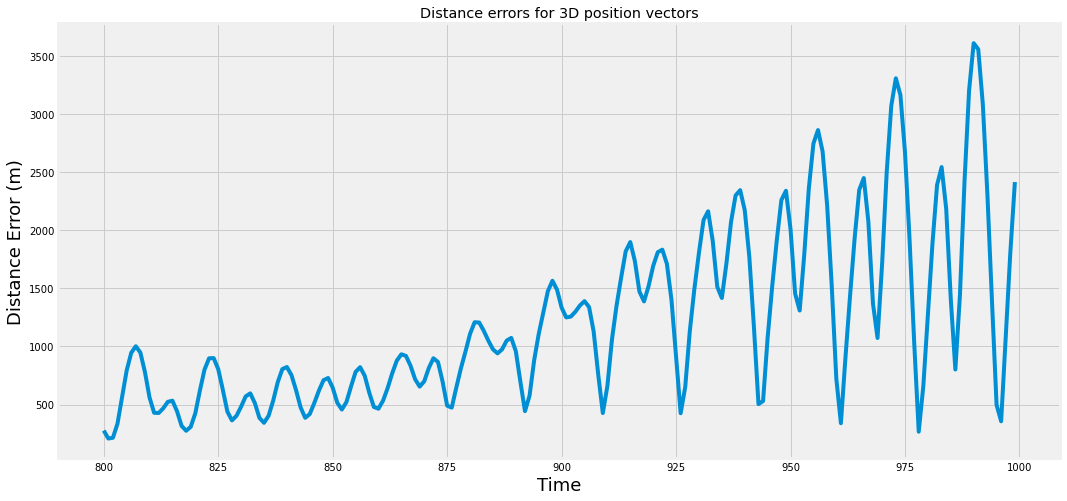

In [36]:
plt.figure(figsize=(16,8))
plt.plot(df_err.distance_error)
plt.title('Distance errors for 3D position vectors')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Distance Error (m)', fontsize=18)
plt.show()

### 2. Absolute errors

??